<span style="color:red">[1.5 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance. </span>


The purpose of this data is for machines to be able to identify different parts based on a new picture of them. machines that are attempting to build PCs and need to utilize cameras to locate certain parts for removal or insertion This includes, for example, correctly identifying a keyboard versus a RAM chip, so that it does not choose the wrong item or damage any components. Another use for our classifier is to sort scrap components from actual usable parts when recycling computers, as well as to remove any toxic parts from going to the landfill. For example, before trash goes into a land fill a camera would scan for certain parts.

### In these cases, false positives and false negatives could have significant costs:

1. A false positive (misclassifying a non-toxic part as toxic) could lead to unnecessary costs for special handling or disposal. [this is closely related to precision ]
2. A false negative (misclassifying a toxic part as non-toxic) could lead to environmental damage and potential legal liabilities. [this is closely related to recall]

### therefore we are planning to use F1score
The F1 score is the harmonic mean of precision and recall, so it balances these two types of errors. If we used precision alone, our model might be too cautious and miss some toxic parts. If we used recall alone, our model might over-predict the toxic parts, leading to unnecessary costs. The F1 score balances these two concerns.

Also, it is Suitable for Uneven Class Distribution. In our case, the number of images for each type of PC part varies, so this is important.

The F1 score can be extended to multi-class classification problems by calculating the F1 score for each class and then taking the average (macro-average) or by considering the total true positives, false negatives, and false positives (micro-average). This makes it suitable for your problem, where you're classifying multiple types of PC parts.

<span style="color:red">[1.5 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. </span>

We will use Stratified k-fold sampling, because it is a good choice when dealing with imbalanced datasets. In stratified k-fold cross-validation, the data is split in a way that preserves the same proportions of examples in each class as observed in the original dataset. This ensures that one class of data is not overrepresented especially when the target variable is unbalanced. It is a realistic mirroring of how an algorithm would be used in practice because it ensures that the model gets to train on an equal representation of each class, similar to what it would encounter when making predictions on real-world data.

In [1]:
import keras
import os
import struct
import numpy as np
import tensorflow as tf
import cv2
import tensorflow.keras as keras

# from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout, MaxPooling2D, Conv2D, Dense, Flatten, Activation, Reshape, Input, RandomFlip, RandomRotation, average
# from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2


def load_dataset(path):
    images = []
    labels = []
    label_classes = os.listdir(path)
    for label in label_classes:
        img_names = os.listdir(os.path.join(path, label))
        for img_name in img_names:
            img = cv2.imread(os.path.join(path, label, img_name), cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (28, 28))
            images.append(img)
            labels.append(label)
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

X, y = load_dataset('1000pc_parts')

# Normalize the images.
X = X.reshape(X.shape[0], 28, 28, 1) / 255.0 - 0.5

# Use LabelEncoder to encode labels into integers
le = LabelEncoder()
y = le.fit_transform(y)

# Number of classes
NUM_CLASSES = len(np.unique(y))

# One-hot encode the labels
y_ohe = to_categorical(y, NUM_CLASSES)

# Stratified 10-fold cross-validation
# skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
#use this for training the thing
# for train_index, test_index in skf.split(X, y):
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y_ohe[train_index], y_ohe[test_index]
#     # Now you can train your model on X_train, y_train and validate it on X_test, y_test

In [2]:

%matplotlib inline

def compare_mlp_cnn(cnn, mlp, X_test, y_test, labels='auto'):
    plt.figure(figsize=(15,5))
    if cnn is not None:
        yhat_cnn = np.argmax(cnn.predict(X_test), axis=1)
        
        
        y_test_int = np.argmax(y_test, axis=1)  # Convert y_test to integer labels
        acc_cnn = mt.accuracy_score(y_test_int,yhat_cnn)
        
        
        # acc_cnn = mt.accuracy_score(y_test,yhat_cnn)
        plt.subplot(1,2,1)
        # cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = mt.confusion_matrix(y_test_int,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f',xticklabels=labels,yticklabels=labels)
        plt.title(f'CNN: {acc_cnn:.4f}')
    
    if mlp is not None:
        yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
        
        
        y_test_int = np.argmax(y_test, axis=1)  # Convert y_test to integer labels
        acc_mlp = mt.accuracy_score(y_test_int,yhat_cnn)
        
        
        # acc_mlp = mt.accuracy_score(y_test,yhat_mlp)
        
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test_int,yhat_mlp)
        # cm = mt.confusion_matrix(y_test,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f',xticklabels=labels,yticklabels=labels)
        plt.title(f'MLP: {acc_mlp:.4f}')
labels = [
    "speakers",
    "webcam",
    "mouse",
    "keyboard",
    "microphone",
    "headset",
    "cpu",
    "gpu",
]

<span style="color:red">[1.5 points]  Setup the training to use data expansion in Keras (also called data augmentation). Explain why the chosen data expansion techniques are appropriate for your dataset. You should make use of Keras augmentation layers, like in the class examples.</span>


We performed data augmentation techniques such as horizontal flip and random rotation are appropriate for our dataset of PC parts because these techniques can help the model generalize better. We are essentially providing more varied data for the model to learn from. 

Horizontal flip and Random rotation works well for our dataset because PC parts, like a graphics card or a motherboard, can be photographed or viewed from various angles in real-world scenarios. Flipping the image horizontally can simulate the scenario where the part is placed or viewed from a different angle.

These augmentation techniques help to create a more diverse training set, which can improve the robustness of the model it's ability to generalize from the training data to unseen data, thereby improving its performance.


In [3]:
# %%time
# Define data augmentation

data_augmentation = Sequential([
        RandomFlip("horizontal"),
        RandomRotation(0.2),
])
# make a keras MLP
def createMLP():
        mlp = Sequential()
        mlp.add(data_augmentation)
        mlp.add( Flatten() )
        mlp.add( Dense(input_dim=1, units=100, activation='relu') )
        mlp.add( Dense(units=50, activation='relu') )
        mlp.add( Dense(units=50, activation='relu') )
        mlp.add( Dense(NUM_CLASSES) )
        mlp.add( Activation('softmax') )

        mlp.compile(loss='categorical_crossentropy',
                optimizer='rmsprop',
                metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

        input_shape = [None, 28,28,1]
        mlp.build(input_shape)
        return mlp

        # mlp.fit(X_train, y_train_ohe, 
        #         batch_size=32, epochs=3, 
        #         shuffle=True, verbose=1)

In [59]:
def createCNN1():
    cnn1 = Sequential()
    cnn1.add(data_augmentation)
    num_filt_layers = [24, 24]
    for num_filters in num_filt_layers:
        cnn1.add( Conv2D(filters=num_filters, 
                        kernel_size=(3,3), 
                        padding='same') )
        cnn1.add( Activation('relu'))
        cnn1.add( MaxPooling2D(pool_size=(2, 2), 
                            ) )
        

    # add one layer on flattened output
    cnn1.add( Flatten() )
    cnn1.add( Dense(100, activation='relu') )
    cnn1.add( Dense(100, activation='relu') )
    cnn1.add( Dense(NUM_CLASSES, activation='softmax') )
    
    cnn1.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])  
    input_shape = [None, 28,28,1]
    cnn1.build(input_shape)  
    return cnn1

def createCNN2():
    cnn2 = Sequential()
    cnn2.add(data_augmentation)
    # let's start with an AlexNet style convolutional phase
    cnn2.add(Conv2D(filters=32,
                    input_shape = (28,28,1),
                    kernel_size=(3,3), 
                    padding='same', 
                    activation='relu')) # more compact syntax

    # no max pool before next conv layer!!
    cnn2.add(Conv2D(filters=64,
                    kernel_size=(3,3), 
                    padding='same', 
                    activation='relu')) # more compact syntax
    cnn2.add(MaxPooling2D(pool_size=(2, 2)))
        

    # add one layer on flattened output
    cnn2.add(Dropout(0.25)) # add some dropout for regularization after conv layers
    cnn2.add(Flatten())
    cnn2.add(Dense(128, activation='relu'))
    cnn2.add(Dropout(0.5)) # add some dropout for regularization, again!
    cnn2.add(Dense(NUM_CLASSES, activation='softmax'))

    # Let's train the model 
    cnn2.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='rmsprop', # 'adadelta' 'rmsprop'
                metrics=['accuracy',tf.keras.metrics.AUC(name='auc')])
    input_shape = [None, 28,28,1]
    cnn2.build(input_shape)  
    return cnn2
def createCNN3():
    cnn3 = Sequential()
    cnn3.add(data_augmentation)
    num_filt_layers = [32, 32]  # Changed number of filters
    for num_filters in num_filt_layers:
        cnn3.add(Conv2D(filters=num_filters, 
                        kernel_size=(5,5),  # Changed kernel size
                        padding='same'))
        cnn3.add(Activation('relu'))
        cnn3.add(MaxPooling2D(pool_size=(2, 2)))

    # add one layer on flattened output
    cnn3.add(Flatten())
    cnn3.add(Dense(128, activation='relu'))  # Changed number of neurons
    cnn3.add(Dense(128, activation='relu'))  # Changed number of neurons
    cnn3.add(Dense(NUM_CLASSES, activation='softmax'))
    
    cnn3.compile(loss='mean_squared_error',
              optimizer='adam',  # Changed optimizer
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])  
    input_shape = [None, 28,28,1]
    cnn3.build(input_shape)  
    return cnn3

def createCNN4():
    cnn4 = Sequential()
    cnn4.add(data_augmentation)
    cnn4.add(Conv2D(filters=48,  # Changed number of filters
                    input_shape = (28,28,1),
                    kernel_size=(5,5),  # Changed kernel size
                    padding='same', 
                    activation='relu'))

    cnn4.add(Conv2D(filters=96,  # Changed number of filters
                    kernel_size=(5,5),  # Changed kernel size
                    padding='same', 
                    activation='relu'))
    cnn4.add(MaxPooling2D(pool_size=(2, 2)))

    cnn4.add(Dropout(0.3))  # Changed dropout rate
    cnn4.add(Flatten())
    cnn4.add(Dense(256, activation='relu'))  # Changed number of neurons
    cnn4.add(Dropout(0.5)) 
    cnn4.add(Dense(NUM_CLASSES, activation='softmax'))

    cnn4.compile(loss='categorical_crossentropy',
                optimizer='adam',  # Changed optimizer
                metrics=['accuracy',tf.keras.metrics.AUC(name='auc')])
    input_shape = [None, 28,28,1]
    cnn4.build(input_shape)  
    return cnn4


<span style="color:red">[2 points] Create a convolutional neural network to use on your data using Keras. Investigate at least two different convolutional network architectures and investigate changing one or more parameters of each architecture such as the number of filters. This means, at a  minimum, you will train a total of four models (2 different architectures, with 2 parameters changed in each architecture). Use the method of train/test splitting and evaluation metric that you argued for at the beginning of the lab. Visualize the performance of the training and validation sets per iteration (use the "history" parameter of Keras). Be sure that models converge. <span>

In [5]:
import matplotlib.pyplot as plt

def plot_histories(histories, labels):
    # Create new labels list with labels for both training and validation lines
    # new_labels = [f'{label} Train' for label in labels] + [f'{label} Validation' for label in labels]
    new_labels = [f'{labels[i//2]} {["Train", "Validation"][i%2]}' for i in range(2*len(labels))]
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    for history, label in zip(histories, labels):
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(new_labels, loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    for history, label in zip(histories, labels):
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(new_labels, loc='upper left')
    plt.show()

In [56]:
# %%time
# Define data augmentation

data_augmentation = Sequential([
        RandomFlip("horizontal"),
        RandomRotation(0.2),
])
# make a keras MLP
def createMLP():
        mlp = Sequential()
        mlp.add(data_augmentation)
        mlp.add( Flatten() )
        mlp.add( Dense(input_dim=1, units=100, activation='relu') )
        mlp.add( Dense(units=50, activation='relu') )
        mlp.add( Dense(units=50, activation='relu') )
        mlp.add( Dense(NUM_CLASSES) )
        mlp.add( Activation('softmax') )

        mlp.compile(loss='categorical_crossentropy',
                optimizer='rmsprop',
                metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

        input_shape = [None, 28,28,1]
        mlp.build(input_shape)
        return mlp

        # mlp.fit(X_train, y_train_ohe, 
        #         batch_size=32, epochs=3, 
        #         shuffle=True, verbose=1)

In [57]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D


def TransferCNN():
    # Load pre-trained MobileNet model without the top layers
    data_augmentation = Sequential([
        RandomFlip("horizontal"),
        RandomRotation(0.2),
    ])
    
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

    # Add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Add a fully-connected layer
    x = Dense(1024, activation='relu')(x)

    # Add a logistic layer with the number of classes
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)

    # Define the model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    model = Sequential([
        data_augmentation,
        model
    ])

    # Freeze the layers of the base model (we won't update the weights during training)
    for layer in base_model.layers:
        layer.trainable = False

    # Compile the model
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy',tf.keras.metrics.AUC(name='auc')])
    return model



__TODO__ explain that our laptops are not good enough to run it with 10 splits, so I did 2 splits, and also explain that it takes too long to see how far each model should go so I just chose 10 for them all (addy please take the time to comment out all of them, increase the epoch amount, and choose the point where they start to converge)

X_train shape: (946, 28, 28, 1)
X_test shape: (237, 28, 28, 1)
y_train shape: (946, 8)
y_test shape: (237, 8)
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 276ms/step


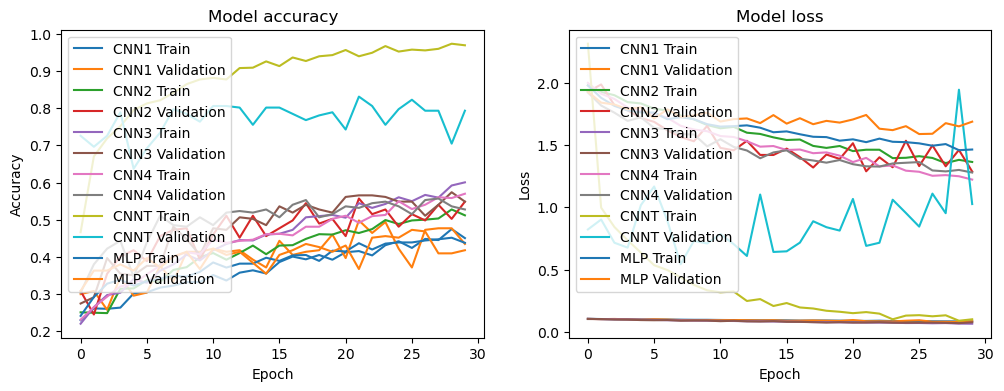

X_train shape: (946, 28, 28, 1)
X_test shape: (237, 28, 28, 1)
y_train shape: (946, 8)
y_test shape: (237, 8)
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 248ms/step


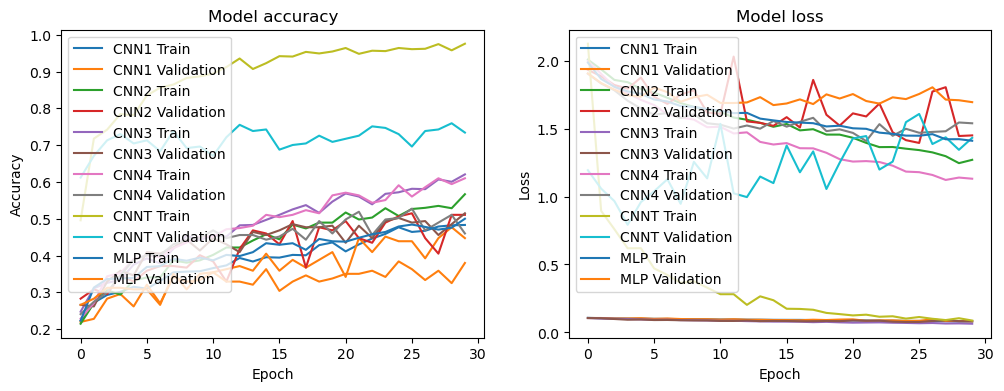

X_train shape: (946, 28, 28, 1)
X_test shape: (237, 28, 28, 1)
y_train shape: (946, 8)
y_test shape: (237, 8)
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 258ms/step


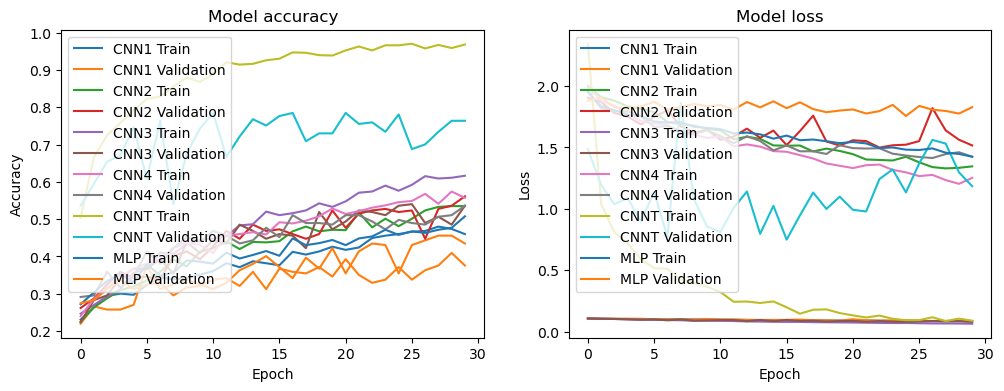

X_train shape: (947, 28, 28, 1)
X_test shape: (236, 28, 28, 1)
y_train shape: (947, 8)
y_test shape: (236, 8)
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 274ms/step


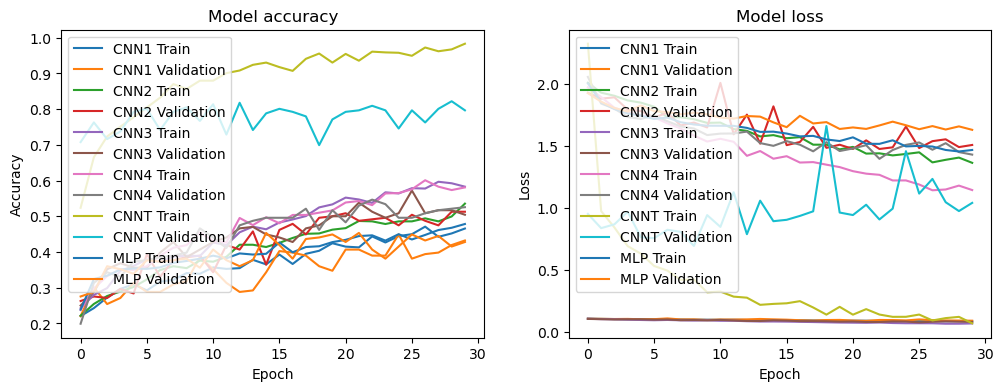

X_train shape: (947, 28, 28, 1)
X_test shape: (236, 28, 28, 1)
y_train shape: (947, 8)
y_test shape: (236, 8)
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 278ms/step


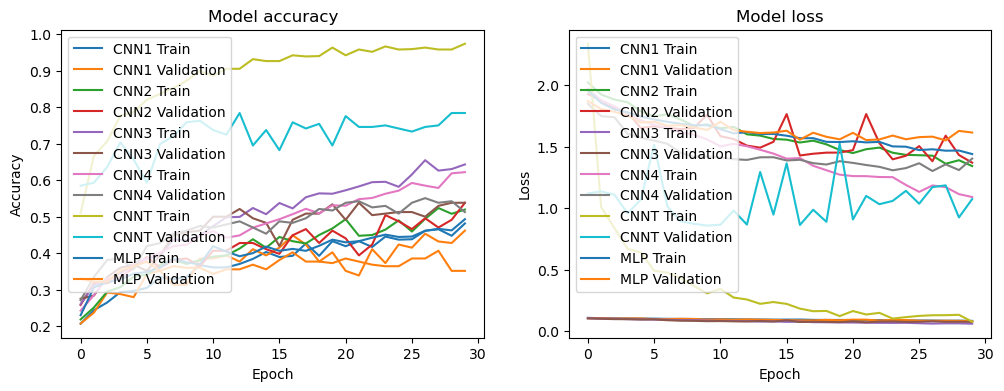

In [60]:
from sklearn.metrics import roc_auc_score

# Stratified 10-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cnn1_accuracies = []
cnn2_accuracies = []
cnn3_accuracies = []
cnn4_accuracies = []
cnnT_accuracies = []
mlp_accuracies = []
cnn1_auc_scores = []
cnn2_auc_scores = []
cnn3_auc_scores = []
cnn4_auc_scores = []
cnnT_auc_scores = []
mlp_auc_scores = []
#use this for training the thing
es = 30
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_ohe[train_index], y_ohe[test_index]
    print('X_train shape:', X_train.shape) 
    print('X_test shape:', X_test.shape)

    print('y_train shape:', y_train.shape) 
    print('y_test shape:', y_test.shape)
    
    # Train and evaluate the first CNN
    cnn1 = createCNN1()
    history1 = cnn1.fit(X_train, y_train, batch_size=32, epochs=es, shuffle=True, verbose=0, validation_data=(X_test,y_test))
    cnn1_accuracies.append(history1.history['val_accuracy'][-1])
    y_pred_probs = cnn1.predict(X_test)  # Predict the probabilities of the positive class
    cnn1_auc_scores.append(roc_auc_score(y_test, y_pred_probs))  # Calculate the AUC score

    # cnn1_auc_scores.append(history1.history['val_auc'][-1])  # Extract AUC from history

    # Train and evaluate the second CNN
    cnn2 = createCNN2()
    history2 = cnn2.fit(X_train, y_train, batch_size=32, epochs=es, shuffle=True, verbose=0, validation_data=(X_test,y_test))
    cnn2_accuracies.append(history2.history['val_accuracy'][-1])
    y_pred_probs = cnn2.predict(X_test)  # Predict the probabilities of the positive class
    cnn2_auc_scores.append(roc_auc_score(y_test, y_pred_probs))  # Calculate the AUC score

    # cnn2_auc_scores.append(history2.history['val_auc'][-1])  # Extract AUC from history
    
    # Train and evaluate the third CNN
    cnn3 = createCNN3()
    history3 = cnn3.fit(X_train, y_train, batch_size=32, epochs=es, shuffle=True, verbose=0, validation_data=(X_test,y_test))
    cnn3_accuracies.append(history3.history['val_accuracy'][-1])
    y_pred_probs = cnn3.predict(X_test)  # Predict the probabilities of the positive class
    cnn3_auc_scores.append(roc_auc_score(y_test, y_pred_probs))  # Calculate the AUC score

    # cnn3_auc_scores.append(history3.history['val_auc'][-1])

    # Train and evaluate the fourth CNN
    cnn4 = createCNN4()
    history4 = cnn4.fit(X_train, y_train, batch_size=32, epochs=es, shuffle=True, verbose=0, validation_data=(X_test,y_test))
    cnn4_accuracies.append(history4.history['val_accuracy'][-1])
    y_pred_probs = cnn4.predict(X_test)  # Predict the probabilities of the positive class
    cnn4_auc_scores.append(roc_auc_score(y_test, y_pred_probs))  # Calculate the AUC score

    # cnn4_auc_scores.append(history4.history['val_auc'][-1])

    # Train and evaluate the MLP
    mlp = createMLP()
    # history_mlp = mlp.fit(X_train, y_train, batch_size=32, epochs=es, shuffle=True, verbose=0)
    history_mlp = mlp.fit(X_train, y_train, batch_size=32, epochs=es, shuffle=True, verbose=0, validation_data=(X_test, y_test))
    mlp_accuracies.append(history_mlp.history['val_accuracy'][-1])
    y_pred_probs = mlp.predict(X_test)  # Predict the probabilities of the positive class
    mlp_auc_scores.append(roc_auc_score(y_test, y_pred_probs))
    # mlp_auc_scores.append(history_mlp.history['val_auc'][-1])  # Extract AUC from history
    
    # Train and evaluate the transfer learning CNN
    cnnT = TransferCNN()
    # Resize and convert images to RGB
    X_train_rgb = np.array([cv2.cvtColor(cv2.resize(img.astype('float32'), (128, 128)), cv2.COLOR_GRAY2RGB) for img in X_train])
    X_test_rgb = np.array([cv2.cvtColor(cv2.resize(img.astype('float32'), (128, 128)), cv2.COLOR_GRAY2RGB) for img in X_test])

    # Now, you can use these RGB images to train your model
    historyT = cnnT.fit(X_train_rgb, y_train, epochs=es, verbose=0, validation_data=(X_test_rgb, y_test))
    cnnT_accuracies.append(historyT.history['val_accuracy'][-1])
    y_pred_probs = cnnT.predict(X_test_rgb)  # Predict the probabilities of the positive class
    cnnT_auc_scores.append(roc_auc_score(y_test, y_pred_probs))  # Calculate the AUC score

    # cnnT_auc_scores.append(historyT.history['val_auc'][-1])
        
    # Assuming history1, history2, history3, history4, and history_mlp are the history objects for cnn1, cnn2, cnn3, cnn4, and mlp respectively
    plot_histories([history1, history2, history3, history4, historyT, history_mlp], ['CNN1', 'CNN2', 'CNN3', 'CNN4','CNNT', 'MLP'])
    # plot_histories([history1, history_mlp], ['CNN1', 'MLP'])
    
   
    # history = cnn1.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
    
    # score = cnn1.evaluate(X_test, y_test, verbose=0)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
F1 score for CNN1: 0.4489104745882911
F1 score for CNN2: 0.5265950440504794
F1 score for CNN3: 0.5356491721865164
F1 score for CNN4: 0.5000952549815755
F1 score for CNNT: 0.7850069652890144
F1 score for MLP: 0.335134039323954


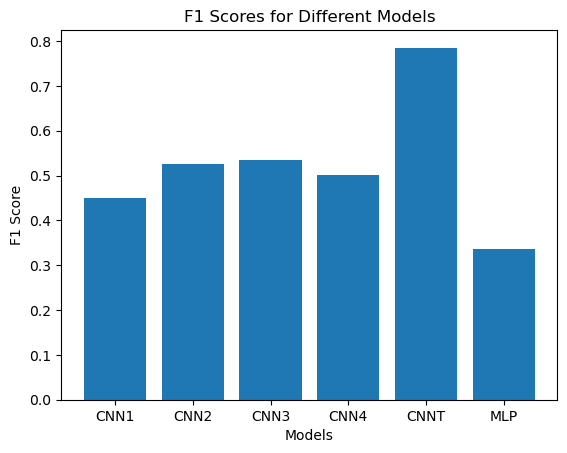

In [61]:
from sklearn.metrics import f1_score

# Predict the probabilities and convert to one-hot encoded labels for each model

y_pred_probs = cnn1.predict(X_test)
cnn1_predicted_labels = to_categorical(np.argmax(y_pred_probs, axis=1))

y_pred_probs_cnn2 = cnn2.predict(X_test)
cnn2_predicted_labels = to_categorical(np.argmax(y_pred_probs_cnn2, axis=1))

y_pred_probs_cnn3 = cnn3.predict(X_test)
cnn3_predicted_labels = to_categorical(np.argmax(y_pred_probs_cnn3, axis=1))

y_pred_probs_cnn4 = cnn4.predict(X_test)
cnn4_predicted_labels = to_categorical(np.argmax(y_pred_probs_cnn4, axis=1))

y_pred_probs_cnnT = cnnT.predict(X_test_rgb)
cnnT_predicted_labels = to_categorical(np.argmax(y_pred_probs_cnnT, axis=1))

y_pred_probs_mlp = mlp.predict(X_test)
mlp_predicted_labels = to_categorical(np.argmax(y_pred_probs_mlp, axis=1))



# Compute F1 scores for each model
f1_cnn1 = f1_score(y_test, cnn1_predicted_labels, average='weighted')
f1_cnn2 = f1_score(y_test, cnn2_predicted_labels, average='weighted')
f1_cnn3 = f1_score(y_test, cnn3_predicted_labels, average='weighted')
f1_cnn4 = f1_score(y_test, cnn4_predicted_labels, average='weighted')
f1_cnnT = f1_score(y_test, cnnT_predicted_labels, average='weighted')
f1_mlp = f1_score(y_test, mlp_predicted_labels, average='weighted')

# Print F1 scores for each model
print('F1 score for CNN1:', f1_cnn1)
print('F1 score for CNN2:', f1_cnn2)
print('F1 score for CNN3:', f1_cnn3)
print('F1 score for CNN4:', f1_cnn4)
print('F1 score for CNNT:', f1_cnnT)
print('F1 score for MLP:', f1_mlp)
import matplotlib.pyplot as plt

# Define the models and their corresponding F1 scores
models = ['CNN1', 'CNN2', 'CNN3', 'CNN4', 'CNNT', 'MLP']
f1_scores = [f1_cnn1, f1_cnn2, f1_cnn3, f1_cnn4, f1_cnnT, f1_mlp]

# Plot the F1 scores
plt.bar(models, f1_scores)
plt.xlabel('Models')
plt.ylabel('F1 Score')
plt.title('F1 Scores for Different Models')
plt.show()


In [62]:
from numpy import argmax

# Convert one-hot encoded y_test back to its original format
y_test_original = argmax(y_test, axis=1)

# Compute confusion matrix for each model
cm_cnn1 = confusion_matrix(y_test_original, argmax(cnn1_predicted_labels, axis=1))
cm_cnn2 = confusion_matrix(y_test_original, argmax(cnn2_predicted_labels, axis=1))
cm_cnn3 = confusion_matrix(y_test_original, argmax(cnn3_predicted_labels, axis=1))
cm_cnn4 = confusion_matrix(y_test_original, argmax(cnn4_predicted_labels, axis=1))
cm_cnnT = confusion_matrix(y_test_original, argmax(cnnT_predicted_labels, axis=1))
cm_mlp = confusion_matrix(y_test_original, argmax(mlp_predicted_labels, axis=1))

# Print confusion matrix for each model
print('Confusion matrix for CNN1:')
print(cm_cnn1)
print('Confusion matrix for CNN2:')
print(cm_cnn2)
print('Confusion matrix for CNN3:')
print(cm_cnn3)
print('Confusion matrix for CNN4:')
print(cm_cnn4)
print('Confusion matrix for CNNT:')
print(cm_cnnT)
print('Confusion matrix for MLP:')
print(cm_mlp)

Confusion matrix for CNN1:
[[ 5  3  1  2  1  0  2  1]
 [ 0  6  0  3  1  0  6  3]
 [ 0  2 13  7  2  0  5  1]
 [ 1  7  0 23  1  0  5 12]
 [ 0  0  1  2  2  0  1  6]
 [ 1  0  0  8  1  6 11  6]
 [ 0  4  2  1  0  0 31 14]
 [ 0  0  1  1  0  0  1 23]]
Confusion matrix for CNN2:
[[ 5  1  2  4  0  0  3  0]
 [ 0  4  0 13  0  0  1  1]
 [ 0  1 18  7  1  1  2  0]
 [ 0  4  1 35  0  2  2  5]
 [ 0  0  1  3  3  0  0  5]
 [ 0  1  2  6  0 11  8  5]
 [ 0  2  4  5  0  1 34  6]
 [ 0  0  0  3  0  0  6 17]]
Confusion matrix for CNN3:
[[ 4  2  0  4  0  2  1  2]
 [ 0  7  0 11  0  0  0  1]
 [ 0  1 17  6  0  0  5  1]
 [ 2  5  0 32  0  4  2  4]
 [ 0  0  0  3  3  0  1  5]
 [ 0  2  2  4  0 17  8  0]
 [ 0  5  4  3  0  3 33  4]
 [ 0  2  1  3  0  3  3 14]]
Confusion matrix for CNN4:
[[ 7  1  1  4  0  1  0  1]
 [ 0  4  0 14  0  0  0  1]
 [ 0  1 17  7  0  2  2  1]
 [ 2  3  1 37  0  2  1  3]
 [ 0  0  1  7  1  0  1  2]
 [ 1  2  2 10  0  9  7  2]
 [ 0  5  5  8  1  0 29  4]
 [ 0  2  1  4  0  1  1 17]]
Confusion matrix for CNN

In [ ]:
# Compute average AUC and accuracy for each model
avg_auc_cnn1 = np.mean(cnn1_auc_scores)
avg_auc_cnn2 = np.mean(cnn2_auc_scores)
avg_auc_cnn3 = np.mean(cnn3_auc_scores)
avg_auc_cnn4 = np.mean(cnn4_auc_scores)
avg_auc_cnnT = np.mean(cnnT_auc_scores)
avg_auc_mlp = np.mean(mlp_auc_scores)

avg_acc_cnn1 = np.mean(cnn1_accuracies)
avg_acc_cnn2 = np.mean(cnn2_accuracies)
avg_acc_cnn3 = np.mean(cnn3_accuracies)
avg_acc_cnn4 = np.mean(cnn4_accuracies)
avg_acc_cnnT = np.mean(cnnT_accuracies)
avg_acc_mlp = np.mean(mlp_accuracies)

from sklearn.metrics import f1_score

# Compute F1 scores for each model
f1_cnn1 = f1_score(true_labels, cnn1_predicted_labels, average='weighted')
f1_cnn2 = f1_score(true_labels, cnn2_predicted_labels, average='weighted')
f1_cnn3 = f1_score(true_labels, cnn3_predicted_labels, average='weighted')
f1_cnn4 = f1_score(true_labels, cnn4_predicted_labels, average='weighted')
f1_cnnT = f1_score(true_labels, cnnT_predicted_labels, average='weighted')
f1_mlp = f1_score(true_labels, mlp_predicted_labels, average='weighted')

# Print F1 scores for each model
print('F1 score for CNN1:', f1_cnn1)
print('F1 score for CNN2:', f1_cnn2)
print('F1 score for CNN3:', f1_cnn3)
print('F1 score for CNN4:', f1_cnn4)
print('F1 score for CNNT:', f1_cnnT)
print('F1 score for MLP:', f1_mlp)


# Print average AUC and accuracy for each model
print('Average AUC for CNN1:', avg_auc_cnn1)
print('Average AUC for CNN2:', avg_auc_cnn2)
print('Average AUC for CNN3:', avg_auc_cnn3)
print('Average AUC for CNN4:', avg_auc_cnn4)
print('Average AUC for CNNT:', avg_auc_cnnT)
print('Average AUC for MLP:', avg_auc_mlp)

print('Average accuracy for CNN1:', avg_acc_cnn1)
print('Average accuracy for CNN2:', avg_acc_cnn2)
print('Average accuracy for CNN3:', avg_acc_cnn3)
print('Average accuracy for CNN4:', avg_acc_cnn4)
print('Average accuracy for CNNT:', avg_acc_cnnT)
print('Average accuracy for MLP:', avg_acc_mlp)

import matplotlib.pyplot as plt

# Average accuracies
plt.figure(figsize=(10, 5))
plt.bar(['CNN1', 'CNN2', 'CNN3', 'CNN4','CNNT', 'MLP'], [avg_acc_cnn1, avg_acc_cnn2, avg_acc_cnn3, avg_acc_cnn4, avg_acc_cnnT, avg_acc_mlp])
plt.title('Average Accuracies of Models')
plt.ylabel('Accuracy')
plt.show()

# Average AUC scores
plt.figure(figsize=(10, 5))
plt.bar(['CNN1', 'CNN2', 'CNN3', 'CNN4','CNNT', 'MLP'], [avg_auc_cnn1, avg_auc_cnn2, avg_auc_cnn3, avg_auc_cnn4, avg_acc_cnnT, avg_auc_mlp])
plt.title('Average AUC Scores of Models')
plt.ylabel('AUC Score')
plt.show()

from scipy import stats

# List of all models' accuracies
accuracies = [cnn1_accuracies, cnn2_accuracies, cnn3_accuracies, cnn4_accuracies,cnnT_accuracies, mlp_accuracies]
labels = ['CNN1', 'CNN2', 'CNN3', 'CNN4','CNNT', 'MLP']

# Compare accuracies of all pairs of models
for i in range(len(accuracies)):
    for j in range(i+1, len(accuracies)):
        t_stat, p_val = stats.ttest_rel(accuracies[i], accuracies[j])
        print(f'p-value for {labels[i]} vs {labels[j]} accuracies: {p_val}')

<span style="color:red">One idea (required for 7000 level students): Use transfer learning with pre-trained weights for your initial layers of your CNN. Compare the performance when using transfer learning to your best model from above in terms of classification performance. </span>

### without augmentation

In [41]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load pre-trained MobileNet model without the top layers
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer
x = Dense(1024, activation='relu')(x)

# Add a logistic layer with the number of classes
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model (we won't update the weights during training)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Resize and convert images to RGB
X_train_rgb = np.array([cv2.cvtColor(cv2.resize(img.astype('float32'), (128, 128)), cv2.COLOR_GRAY2RGB) for img in X_train])
X_test_rgb = np.array([cv2.cvtColor(cv2.resize(img.astype('float32'), (128, 128)), cv2.COLOR_GRAY2RGB) for img in X_test])

# Now, you can use these RGB images to train your model
history= model.fit(X_train_rgb, y_train, epochs=20, validation_data=(X_test_rgb, y_test))

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 573ms/step - accuracy: 0.4026 - loss: 3.3664 - val_accuracy: 0.5499 - val_loss: 1.4615
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 502ms/step - accuracy: 0.7856 - loss: 0.6848 - val_accuracy: 0.7597 - val_loss: 0.7550
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 517ms/step - accuracy: 0.9097 - loss: 0.2760 - val_accuracy: 0.6041 - val_loss: 1.3900
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 517ms/step - accuracy: 0.9233 - loss: 0.2411 - val_accuracy: 0.5533 - val_loss: 2.3131
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 523ms/step - accuracy: 0.9136 - loss: 0.4082 - val_accuracy: 0.7462 - val_loss: 0.8643
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 537ms/step - accuracy: 0.9883 - loss: 0.0397 - val_accuracy: 0.4687 - val_loss: 2.4980
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 490ms/step - accuracy: 0.9556 - loss: 0.1848 - val_accuracy: 0.7107 - val_loss: 1.3086
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 468ms/step - accuracy: 0.9644 - loss: 0.0860 - val_accurac

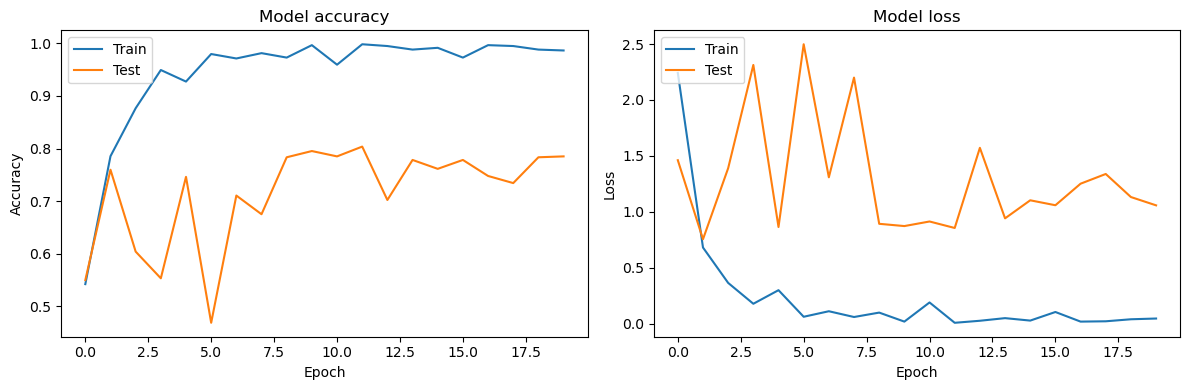

19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 345ms/step
F1 score: 0.7823406127469813


In [42]:
from sklearn.metrics import f1_score
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

# Predict the labels for the test data
y_pred = model.predict(X_test_rgb)
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert the true labels to their original format
y_test_labels = np.argmax(y_test, axis=1)

# Calculate the F1 score
f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')

# Print the F1 score
print('F1 score:', f1)


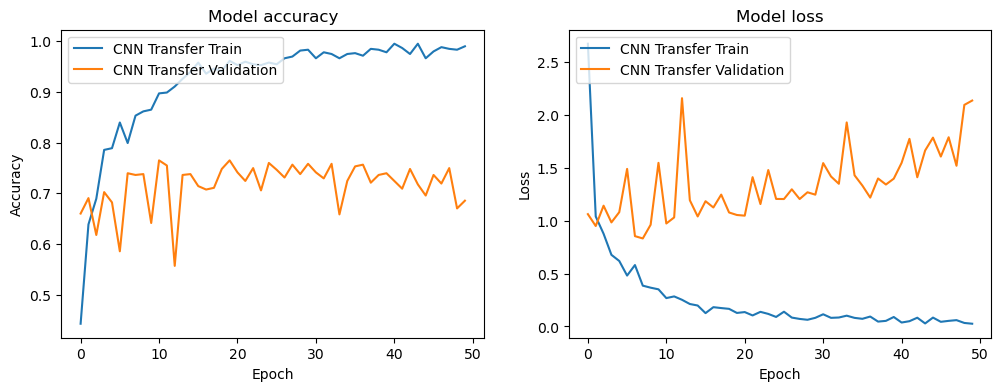

F1 score for CNNT: 0.6941796527970019


In [43]:
# Plot the model accuracy and model loss for cnnT
plot_history(historyT, 'CNN Transfer')
print('F1 score for CNNT:', f1_cnnT)

    

__TODO__ other todo, I made the graphs and outputs, but they aren't being talked about in the markdown. Please interpret and evaluate their performances.

we can see from the graphs that most models Converge around 20 epochs. The plateauing of most models around 20 epochs suggests that further training on the same data is not improving the models' ability to generalize. This is a common sign of the models starting to overfit the training data - they're not learning new, generalizable information after around 20 epochs, just memorizing the training data.

The CNN 3 and 4 models gradually increase in accuracy (and MLP increases very slowly). The continued improvement of CNN 3, CNN 4, and MLP suggests that these models might still learning useful information after 20 epochs. However, it's important to monitor them closely for signs of overfitting.

A similar decreasing pattern can be seen in the model loss.

The transfer model outperforms all of the models we trained by a significant margin. The significant improvement of the transfer learning model suggests that the features learned by the pre-trained model are very useful for your classification task. It's also possible that the pre-trained model has a more effective architecture for this task than the other models you've tried.

